# Iris Dataset Classifier Exercise

## 1. Generate Model and Data

### 1-1. Setup

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import tensorflow as tf
from   tensorflow import keras
import tf2onnx
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

### 1-2. Dataset loading & processing

In [3]:
# load data from scikit-learn library
iris = load_iris()
# onehot coding labels 
label_oneHot = tf.one_hot(iris.target, len(set(iris.target))).numpy()
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, label_oneHot, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120, 3) (30, 3)


### 1-3. Model building and training

In [4]:
# 2 hidden layers with relu
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
  ])

# set optimizer, loss function, and evaluation metrics 
model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model training
model.fit(X_train, y_train, batch_size=1, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
120/120 [==============================] - 2s 5ms/step - loss: 1.1077 - accuracy: 0.2417 - val_loss: 0.9182 - val_accuracy: 0.3667
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.9006 - accuracy: 0.4917 - val_loss: 0.8523 - val_accuracy: 0.6333
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.8462 - accuracy: 0.6500 - val_loss: 0.7932 - val_accuracy: 0.7000
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.7767 - accuracy: 0.6583 - val_loss: 0.7276 - val_accuracy: 0.7000
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6975 - accuracy: 0.7167 - val_loss: 0.6394 - val_accuracy: 0.7000
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6833 - val_loss: 0.5586 - val_accuracy: 0.8000
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.5453 - accuracy: 0.7750 - val_loss: 0.5002 - val_accuracy: 0.8000
Epoch 

### 1-4. Convert model to onnx, data to idx

In [5]:
# convert model to onnx
onnx_model, _ = tf2onnx.convert.from_keras(model, output_path="iris_model.onnx")
# convert data to idx
idx2numpy.convert_to_file('iris_test_data.idx', X_test)
idx2numpy.convert_to_file('iris_test_label.idx', y_test)

## 2. Explore data (to decide logical specification)

### 2-1. Check range of input features

In [6]:
# get min, max
min_values = np.min(iris.data, axis=0)
max_values = np.max(iris.data, axis=0)
print(min_values, max_values)

[4.3 2.  1.  0.1] [7.9 4.4 6.9 2.5]


In [7]:
# get mean, std
mean_values = np.mean(iris.data, axis=0)
std_values = np.std(iris.data, axis=0)
print(mean_values, std_values)

[5.84333333 3.05733333 3.758      1.19933333] [0.82530129 0.43441097 1.75940407 0.75969263]


### 2-2. Draw scatter plots

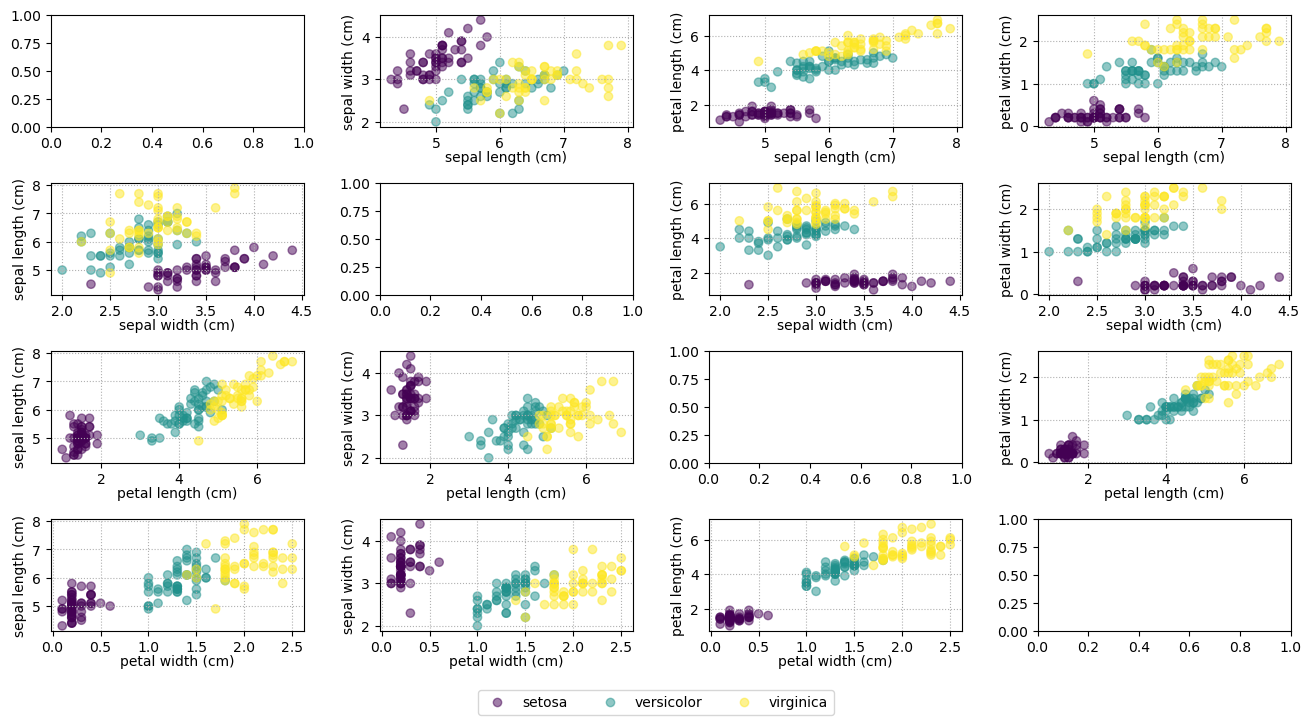

In [8]:
n_features = iris.data.shape[1]

# create subplots for each pair of features
fig, axs = plt.subplots(n_features, n_features, figsize=(16, 8))

# iterate over each pair of features
for i in range(n_features):
    for j in range(n_features):
        # skip diagonal plots 
        if i == j:
            continue    
        ax = axs[i, j]
        scatter = ax.scatter(iris.data[:, i], iris.data[:, j], c=iris.target, label=iris.target_names, alpha=0.5)
        ax.grid(True, linestyle='dotted')
        ax.set_xlabel(iris.feature_names[i], labelpad=0)
        ax.set_ylabel(iris.feature_names[j])
        
# get unique class labels and handles from the scatter plot
handles, labels = scatter.legend_elements()

# Create a single legend for the entire plot
fig.legend(handles, iris.target_names, loc='lower center', ncol=4)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.3, hspace=0.5)

plt.show()

### 2-3. Check relationships between features

In [9]:
# sepal length is always longer than sepal width
np.any(iris.data[:, 0] - iris.data[:, 1] > 0)

True

In [10]:
# petal length is always longer than petal width
np.any(iris.data[:, 2] - iris.data[:, 3] > 0)

True

### 2-4. Check counter examples

In [11]:
counter_example =    [4.3, 2.0, 1.236752, 1.236752]
# convert to tensor and reshape
tensor_sample = tf.constant(counter_example, dtype=tf.float32)
tensor_sample = tf.reshape(tensor_sample, (1, -1))

# predict
model.predict(tensor_sample)

1/1 [==============================] - 0s 257ms/step


array([[ 4.8843484,  4.905523 , -4.667286 ]], dtype=float32)